<h1>Chapter 8: Dimensionality Reduction</h1>

<h2>8.1 Introduction</h2>
Many ML problems involve thousands or even million of features for each training instance. Not only do these features make training extremely slow, but they can also make it harder to find a good solution. This problem is often referred to as <em>the curse of dimensionality</em>.

Fortunately, in real world problems, it's often possible to reduce the number of features considerably. Apart from speding up training, dimensionality reduction is also extremely usefu for data visualisation. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph .

<h2>8.2 The Curse of Dimensionality</h2>
In theory, one solution to the curse of dimensionality could be to increase the size of the trainign set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With jsut 100 features all ranging from 0 to 1, you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

<h2>8.3 Main Approaches for Dimensionality Reduction</h2>
<h3>8.3.1 Projection</h3>

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. 

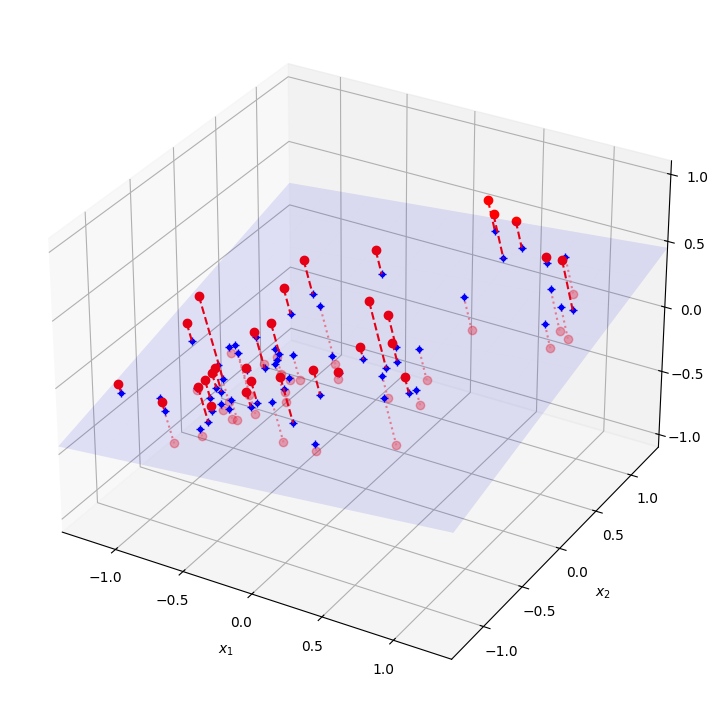

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

Notice in the above plot that all training instances lie close to a plane: this is a lower-dimensional 2D subspace of the higher-dimensional 3D space. If we project every training instance onto this subspace, we get the new 2D dataset shown below.

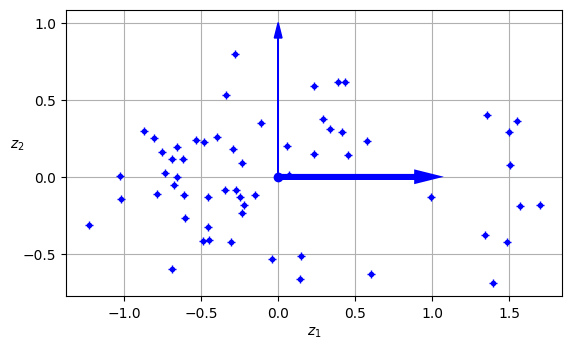

In [3]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

<h3>8.3.2 Manifold Learning</h3>

However, projection isn't always the best approach to dimensionality reduction. In many cases the subspace may twist and turn. Simply projecting onto a plane would squash different layers together.

For example, consider the swiss roll:

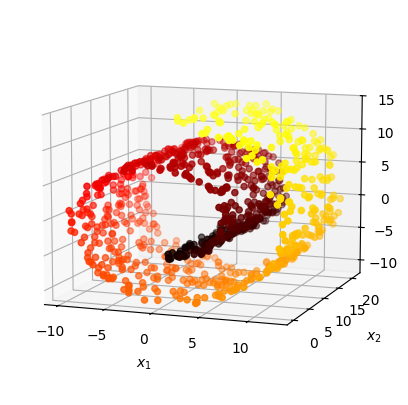

In [4]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
plt.show()

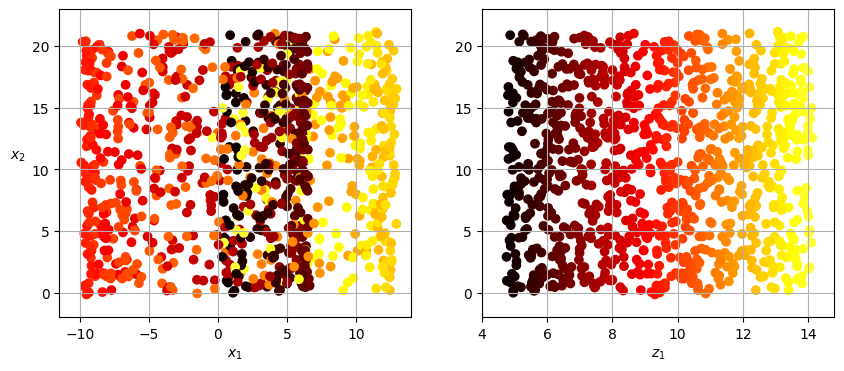

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

We can see the difference bewteen squashing by projecting onto a plane (left) versus unrolling the Swiss roll. 

The Swiss roll is an example of a 2D manifold. Generally, a d-dimensional manifold is part of an n-dimensional space that locally represents a d-dimensional hyperplane. Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called <em>manifold learning</em>. It relies on the <em>manifold assumption</em>, also called the <em>manifold hypothesis</em>, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. 

<h2>8.4 PCA</h4>

<em>Principle Component Analysis</em> (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

<h3>8.4.1 Preserving the Variance</h3>

Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. 

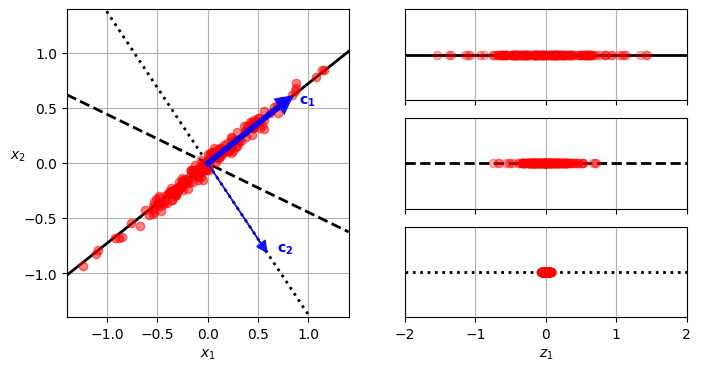

In [6]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()
plt.show()

For example, a simple 2D dataset is represented on the left in the above figure. On the right is the result of the projection of the dataset onto each of these axes. The projection onto the solid line preserves the maximum variance (top), while the projection onto the dotted line preserves very little variance (bottom), and the proejction onto the dashed line preserves an intermediate amount of variance (middle).

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimises the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA. 

<h3>8.4.2 Principal Components</h3>

PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance. In this 2D example, there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, fifth etc - as many axes as the number of dimensions in the dataset.

The $i^{th}$ axis is called the $i^{th}$ <em>principal component</em> (PC) of the data. In the above figure, the first PC is the axis on which vector $c_{1}$ lines, and the second is the axis on which vector $c_{2}$ lines. 

So, how can you find the principal component of a training set? Luckily, there is a standard matrix factorization technique called <em>singular value decomposition</em> (SVD) that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U \Sigma V_{T}$, where V contains the unit vector that defines all the principal components that you're looking for. 

The following code uses NumPy's svd() function to obtain all the principal components of the 3D training set from before, then it extracts the two unit vectors that define the first two PCs:

In [7]:
import numpy as np

X_centered = X - X.mean(axis = 0)

U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

<h3>8.4.3 Projecting Down to d Dimensions</h3>

Once you've identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimension by projecting it onto the hyperplane defined by the first $d$ components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduce dataset $X_{d-proj}$ of dimensionality $d$, compute the matrix multiplication of the training set matrix X by the matrix $W_{d}$, defined as the matrix containing the first $d$ columns of V:

$$
X_{d-proj} = X W_{d}
$$

The following Python code projects the training set onto the hyperplane defined by the first two principal components:

In [8]:
W2 = Vt[:2].T
X2D = X_centered @ W2

<h3>8.4.4 Using Scikit-Learn</h3>

Scikit-Learn's PCA class uses SVD to implement PCA. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions:

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

<h3>8.4.5 Explained Variance Ratio</h3>

Another useful piece of information is the <em>explained variance ratio</em> of each principal component, available via the explained_variance_ratio_ variable. The ratio indicates the proportion of the dataset's variance that lies along each princpal component. 

For example, let's look at the explained variance ratios of the first two components of the 3D dataset from earlier:

In [10]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

This output tells us that about 76% of the dataset's variance lies along the first PC, and aobut 15% lies along the second PC. This leaves about 9% for the third PC, so it's reasonable to assume that the third PC probably carries little information.

<h3>8.4.6 Choosing the Right Number of Dimensions</h3>

Instead of arbitrarily choosing the number of dimensions to reduce down to, it's simpler to choose then number of dimensions that add up to a sufficiently large portion of the variance - say, 95%.

The followign code loads and splits the MNIST dataset and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance:

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

You can then set n_components=d and run PCA again, but there's a better option. 

Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [12]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

np.int64(154)

If you're using dimensionality reduction as a preprocessing step for a supervised learning task, you can tune the number of dimensions as you would any other hyperparameter. 

For example, the following code creates a two-step pipeline, first reducing dimensionality using PCA, then classifying using a random forest. Next, it uses RandomizedSearchCV to find a good combination of hyperparameters for both PCA and the random forest classifier.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state = 42), RandomForestClassifier(random_state = 42))

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter = 10, cv = 3, random_state = 42)

rnd_search.fit(X_train[:1000], y_train[:1000])

rnd_search.best_params_

{'randomforestclassifier__n_estimators': np.int64(475),
 'pca__n_components': np.int64(57)}

In the above example, we reduced a 784-dimensional dataset to just 23 dimensions.

This is tied to the fact we used a random forest, which is a pretty powerful model. If we used a linear model instead, such as an SGDClassifier, the search would find that we need to preserve more dimensions (about 70).

<h3>8.4.7 PCA for Compression</h3>

After dimensionality reduction, the training set takes up much less space. For example, after applying PCA to the MNIST dataset while preserving 95% of its variance, we are left with 154 features, instead of the original 784 features. So, the dataset is now less than 20% of its original size, and we only lost 5% of its variance. 

It's also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformastion of the PCA projection. This won't give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. The mean sqaured distance between the original data and the reconstructed data (compressed and then decompressed) is called the <em>deconstruction error</em>.

The inverse_transform() method lets us decompress the reduced MNIST dataset back to 784 dimensions:

In [14]:
X_recovered = pca.inverse_transform(X_reduced)

The equation for the inverse transformation is given by

$$
X_{recovered} = X_{d-proj} W_{d}^{T}
$$


<h3>8.4.8 Randomised PCA</h3>

If you set the svd_solver hyperparameter to "randomized", Scikit-Leran uses a stochastic algorithm called <em>Randomised PCA</em> that quickly finds an approximation of the first $d$ principal components. Its computational complexity is $O(m \times d^{2}) + O(d^{3})$, instead of $O(m \times n^{2}) + O(n^{3})$ for the full SVD approach, so it's dramatically faster than full SVD when $d$ is much smaller than $n$:

In [15]:
rnd_pca = PCA(n_components = 154, svd_solver = "randomized", random_state = 42)
X_reduced = rnd_pca.fit_transform(X_train)

<h3>8.4.9 Incremental PCA</h3>

One problem with the previous implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, <em>Incremental PCA</em> algorithms have been developed that allow you to split the training set into mini-batches and feed these in one mini-batch at a time. This is useful for large training sets and for aplying PCA online.

In [16]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.fit(X_batch)

X_reduced = inc_pca.transform(X_train)

<h2>8.5 Random Projection</h2>
The random projection algorithm projects the data to a lower-dimensional space using a random linear projection.

William B Johnson and Joram Lindenstrauss demonstrated in a lemma that such a random projection is very likely to preserve distances fairly well. Two similar instances will remain similar after the projection, and two very different instances will remain very different.

So, how can you choose the optimal number of dimensions. The two lads came up with an equation that determines the minimum number of dimensions to presrve in order to ensure - with high probability - that distances won't change by more than a give ntolerance.

This equation is implemented like so:

In [17]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps = e)
d

np.int64(7300)

Now, we can just generate a random matrix P of shape [d, n], where each item is sampled randomly from a Gaussian distribution with mean 0 and variance 1/d, and use it to project a dataset from n dimensions down to d:

In [18]:
n = 20_000

np.random.seed(42)

P = np.random.randn(d, n) / np.sqrt(d) 

X = np.random.randn(m, n)

X_reduced = X @ P.T

The only thing the algorithm needs to create the random matrix is the dataset's shape. The data itself isn't actually used at all. 

Scikit-Learn offers a GaussianRandomProjection class to do exactly what we just did. When you call its fit() method, it uses johnson_lindenstrauss_min_dim() to determine the output dimensionality, then it generates a random matrix, which it stores in teh components_ attribute. Then when you call transform(), it uses this matrix to perform the projection.

In [19]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps = e, random_state = 42)

X_reduced = gaussian_rnd_proj.fit_transform(X)

<h2>8.6 LLE </h6>

Locally Lienar Embedding (LLE) is a nonlinear dimensionality reduction (NLDR) technique. It is a manifold learning technique that doesn't rely on projections, unlike PCA and random projection. It works by first measuring how each training instance linearly relates to its nearest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. This approach makes it particualry good at unrolling twisted manifolds, especially when there's not too much noise.

The following code makes a Swiss roll, then uses Scikit-Learn's LocallyLinearEmbedding class to unroll it:

In [22]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

Here, the variable $t$ is a 1D NumPY array containing the position of each instance along the rolled axis of the Swiss roll. This can be used as a target for a nonlinear regression task.

The resulting 2D dataset is shown below:

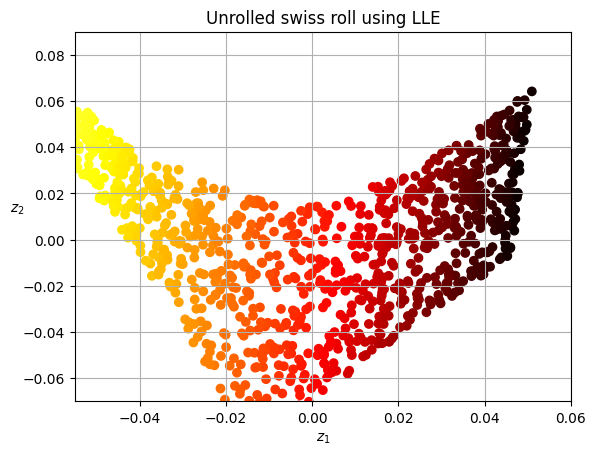

In [23]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

The Swiss roll is completely unrolled, and the distances between instances are locally well preserved. 

However, distances aren't preserved on a larger scale: the unrolled Swiss roll should be a rectangle, not this kind of stretched and twisted band. 